This notebook supports the equations that govern contaminant uptake and impacts on the biology within the Salish Sea Atlantis model. It shows the 1-day output of simulations after injecting PAH components of oil into the water column, to observe biological uptake, as well as non-lethal and lethal impacts relative to a control simulation with no contaminants injected.

Half lives

| PAH Concentration	|	Naphthalene |	Phenanthrene | Pyrene |	Benzo(a)pyrene |
|-------------------|---------------|-----------------|--------|----------|
| Half life (secs)	|	259200 |	3628800	| 20476800	| 19353600 |
| Half life (days)	|	3	| 42 |	237 |	224 |

In [101]:
import os
import re
import xarray as xr
import numpy as np
import pandas as pd
from pathlib import Path
import matplotlib.pyplot as plt
import ssam_groups as groups

In [2]:
control_name = '7a-EquationsPaper-90d-control'
control_file = "/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/"+ control_name + "/outputSalishSea.nc"
control = xr.open_dataset(str(control_file), decode_cf=True)

In [3]:
time = np.ma.filled(control.variables['t'], np.nan)

Runs
- 7a-EquationsPaper-1 - high PL contaminant uptake PL, low PS contaminant uptake
- 7a-EquationsPaper-FHE-effects - low uptake for all species
- 7a-EquationsPaper-ZL-kgrowth - low uptake for all species

others as described in the folder name

In [161]:
scen_name = '7a-EquationsPaper-ALC'
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/')
scenario_paths = sorted([p for p in scenario_root.glob(scen_name+'/outputSalishSea.nc')])
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]
scenario_paths

[PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/7a-EquationsPaper-ALC/outputSalishSea.nc')]

In [162]:
duration_ns = time - time[0]
duration = duration_ns.astype('timedelta64[D]')
duration[1]

numpy.timedelta64(0,'D')

In [163]:
scenario_labels = []
for path in scenario_paths:
    scenario_labels.append(path.parent.stem)

In [89]:
start = 0
end = time.size-1

In [7]:
def compare_scenario_pah(species, pah, boxes=groups.salish_sea):
    fig, ax = plt.subplots(figsize = (14,3))
    names = []
    for scenario, path in zip(scenario_datasets, scenario_paths):
        names.append(path.parent.stem)
        contam_tbl = np.ma.filled(scenario.variables[species+'_' + pah][:,boxes,:], np.nan)
        volume_tbl = np.ma.filled(scenario.variables['volume'][:,boxes,:], np.nan)
        contam_mass_tbl = contam_tbl * volume_tbl
        contam_mass_tb = contam_mass_tbl.sum(axis=2)
        contam_mass_t = contam_mass_tb.sum(axis=1)
        ax.plot(duration, contam_mass_t/1e6)
    ax.legend(names)
    ax.set_ylabel(species + ' PAH (kg)')
    ax.set_title(pah, fontsize = 12);

In [8]:
def print_max_pah_conc(species, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        for pah in groups.pahs:
            contam_tbl = np.ma.filled(scenario.variables[species +'_'+ pah], np.nan)
            contam_tb = contam_tbl.sum(axis=2)
            contam_t = contam_tb.sum(axis=1)
            max_contam_mass = contam_t.max()/1e6
            print(path.parent.stem, species, pah, max_contam_mass)

In [9]:
def group_mass(group, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        fig, ax = plt.subplots(figsize = (14,3))
        nm = path.parent.stem
        for variable in group:
            contam_tbl = np.ma.filled(scenario.variables[variable], np.nan)
            volume_tbl = np.ma.filled(scenario.volume, np.nan)
            time = np.ma.filled(scenario.variables['t'], np.nan)
            contam_mass_tbl = contam_tbl * volume_tbl
            contam_mass_tb = contam_mass_tbl.sum(axis=2)
            contam_mass_t = contam_mass_tb.sum(axis=1)
            ax.plot(time, contam_mass_t/1e6) 
            np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/"+scen_name+"/"+str(variable)+".csv", contam_mass_t, delimiter = ",")
        ax.legend(group,  loc='best')
        ax.set_ylabel('mass (Kg)')
        ax.set_xlabel('Time')
        ax.set_title(nm)

In [95]:
def group_conc(group, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        fig, ax = plt.subplots(figsize = (14,3))
        nm = path.parent.stem
        for variable in group:
            contam_tbl = np.ma.filled(scenario.variables[variable], np.nan)
            time = np.ma.filled(scenario.variables['t'], np.nan)
            contam_tb = contam_tbl.sum(axis=2)
            contam_t = contam_tb.sum(axis=1)
            ax.plot(time, contam_t) #zoom into recruitement of Chinook [40:60]
            #np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/"+scen_name+"/"+str(variable)+".csv", contam_t, delimiter = ",")
        ax.legend(group,  loc='best')
        ax.set_ylabel('Concentration (mg/m$^3$)')
        ax.set_xlabel('Time')
        ax.set_title(nm)

In [11]:
def group_conc_benthic(group, scenario_datasets, scenario_paths):
    for scenario, path in zip(scenario_datasets, scenario_paths):
        fig, ax = plt.subplots(figsize = (14,3))
        nm = path.parent.stem
        for variable in group:
            contam_tb = np.ma.filled(scenario.variables[variable], np.nan)
            time = np.ma.filled(scenario.variables['t'], np.nan)
            contam_t = contam_tb.sum(axis=1)
            np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/"+scen_name+"/"+str(variable)+".csv", contam_t, delimiter = ",")
            ax.plot(time, contam_t) #zoom into recruitement of Chinook [40:60]
        ax.legend(group,  loc='best')
        ax.set_ylabel('Concentration (mg/m$^2$)')
        ax.set_xlabel('Time')
        ax.set_title(nm)

In [ ]:
def compare_groups_pelagic(bio_group, scenario, control, time, start, end, boxes, event_start, y_min=None, y_max=None): #bacteria, plankton
    
    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=label_size)
    ax.set_ylabel('scenario : control')
    ax.set_title('Change in pelagic groups relative to control', fontsize = font_size)

    for species in bio_group:
        oiled_tbl = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:end,boxes,0:6], np.nan) # tonnes
        control_tbl = np.ma.filled(control.variables[bio_group[species] + '_N'][start:end,boxes,0:6], np.nan)
        oiled_tb = oiled_tbl.sum(axis=2)
        oiled_t = oiled_tb.sum(axis=1)
        control_tb = control_tbl.sum(axis=2)
        control_t = control_tb.sum(axis=1)
        ratio = oiled_t / control_t
        control_ratio = control_t / control_t
        ax.plot(time[start:end], ratio, linewidth = 2)
    
    ax.legend(bio_group, loc='best')
    ax.plot(time[start:end], control_ratio, 'k',linewidth = 2)
    ax.plot(event_start, 1, 'ro', alpha=0.5)
    ax.set_ylim([y_min, y_max])
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)

In [21]:
def compare_pelagic_versus_allpah_conc(bio_group, scenario, control, time, start, end, boxes, y_min=None, y_max=None): #bacteria, plankton
    
    fig, ax = plt.subplots(figsize = (14,3))
    ax.tick_params(labelsize=11)
    ax.set_ylabel('% biomass change')

    for species in bio_group:
        oiled_tbl = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:end,boxes,0:6], np.nan) # tonnes
        control_tbl = np.ma.filled(control.variables[bio_group[species] + '_N'][start:end,boxes,0:6], np.nan)
        oiled_t = oiled_tbl.sum(axis=(1,2))
        control_t = control_tbl.sum(axis=(1,2))
        ratio = oiled_t / control_t         
        for pah in groups.pahs:
            contam_tbl = np.ma.filled(scenario.variables[pah][start:end,boxes,0:6], np.nan)
            contam_t = contam_tbl.sum(axis=(1,2))
            ax.semilogx(contam_t, ratio, 'o', label=species +'-'+ pah)
    
    ax.legend(loc='best')
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([0.001, 1000])
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)

In [107]:
def compare_pelagic_versus_pah_chabitat(bio_group, pah, scenario, control, time, start, end, boxes, y_min=None, y_max=None, x_min=0.001, x_max=1000): #bacteria, plankton
    
    fig, ax = plt.subplots(figsize = (4,4))
    ax.tick_params(labelsize=11)
    ax.set_ylabel('% biomass')
    ax.set_xlabel('Concentration of '+pah+' in water (mg/m3)')

    for species in bio_group:
        oiled_tbl = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:end,boxes,0:6], np.nan) # tonnes
        control_tbl = np.ma.filled(control.variables[bio_group[species] + '_N'][start:end,boxes,0:6], np.nan)
        oiled_t = oiled_tbl.sum(axis=(1,2))
        control_t = control_tbl.sum(axis=(1,2))
        ratio = oiled_t / control_t         
        np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/"+scen_name+"/"+str(bio_group[species])+"_"+pah+"-ratio.csv", ratio, delimiter = ",")

        contam_tbl = np.ma.filled(scenario.variables[pah][start:end,boxes,0:6], np.nan)
        contam_t = contam_tbl.sum(axis=(1,2))
        np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/"+scen_name+"/Cenv_"+pah+".csv", contam_t, delimiter = ",")
        ax.semilogx(contam_t, ratio, 'o', label=species)
    ax.legend()
    #ax.set_xscale('log')
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([x_min, x_max])
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)

In [62]:
def plot_biomass(bio_group, scenario, control, time, start, end, boxes, y_min=None, y_max=None): #bacteria, plankton
    
    fig, ax = plt.subplots(figsize = (14,4))
    ax.tick_params(labelsize=11)
    ax.set_ylabel('biomass')
    ax.set_xlabel('time (days)')

    for species in bio_group:
        oiled_tbl = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:end,boxes,0:6], np.nan) # tonnes
        control_tbl = np.ma.filled(control.variables[bio_group[species] + '_N'][start:end,boxes,0:6], np.nan)
        oiled_t = oiled_tbl.sum(axis=(1,2))
        control_t = control_tbl.sum(axis=(1,2))    
        ax.plot(time[start:end], control_t, 'k--', label=species+'-control')
        ax.plot(time[start:end], oiled_t, label=species)
    ax.legend()

In [106]:
def compare_pelagic_versus_pah_cbio(bio_group, pah, scenario, control, time, start, end, boxes, y_min=None, y_max=None, x_min=0.001, x_max=1000): #bacteria, plankton
    
    fig, ax = plt.subplots(figsize = (4,4))
    ax.tick_params(labelsize=11)
    ax.set_ylabel('% biomass (mg N/m3)')
    ax.set_xlabel('Concentration of '+pah+' in bio (mg/m3)')

    for species in bio_group:
        oiled_tbl = np.ma.filled(scenario.variables[bio_group[species] + '_N'][start:end,boxes,0:6], np.nan) # tonnes
        control_tbl = np.ma.filled(control.variables[bio_group[species] + '_N'][start:end,boxes,0:6], np.nan)
        oiled_t = oiled_tbl.sum(axis=(1,2))
        control_t = control_tbl.sum(axis=(1,2))
        ratio = oiled_t / control_t         

        contam_tbl = np.ma.filled(scenario.variables[bio_group[species]+'_'+pah][start:end,boxes,0:6], np.nan)
        contam_t = contam_tbl.sum(axis=(1,2))
        np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/"+scen_name+"/Cbio"+str(bio_group[species])+"_"+pah+".csv", contam_t, delimiter = ",")
        ax.semilogx(contam_t, ratio, 'o', label=species)
    ax.legend()
    #ax.set_xscale('log')
    ax.set_ylim([y_min, y_max])
    ax.set_xlim([x_min, x_max])
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)

### Water Column - without resets

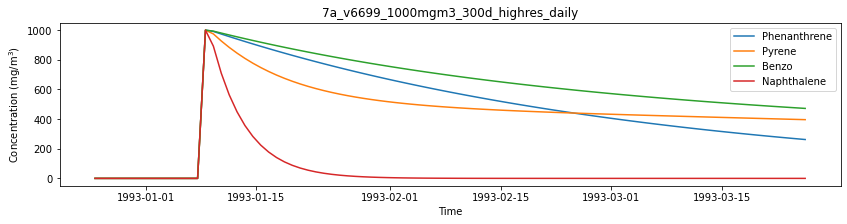

In [12]:
group_conc(groups.pahs, scenario_datasets, scenario_paths)


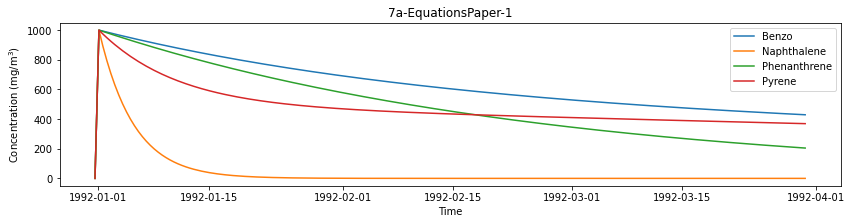

In [14]:
group_conc(groups.pahs, scenario_datasets, scenario_paths)

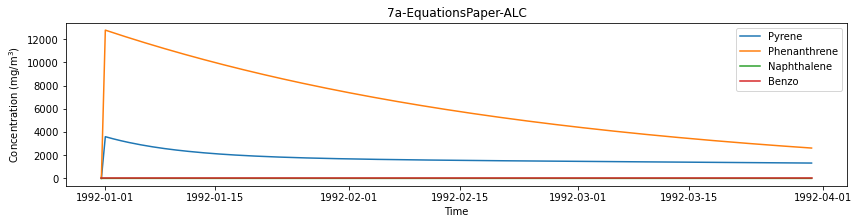

In [96]:
group_conc(groups.pahs, scenario_datasets, scenario_paths)

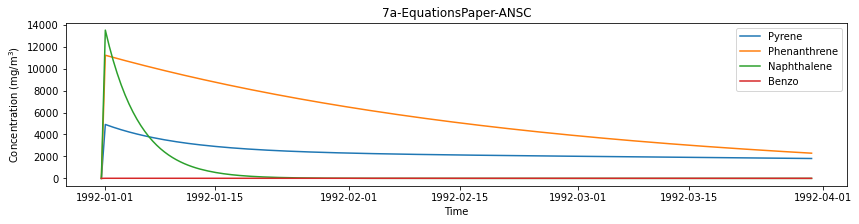

In [99]:
group_conc(groups.pahs, scenario_datasets, scenario_paths)

In [14]:
for scenario in scenario_datasets:
    contam_t = np.ma.filled(scenario.variables['Naphthalene'][:,1,5], np.nan)

In [15]:
num = 13
print('Concentration (mg/m3) of contaminants released in Box 1 on '+str(time[num])+' is '+str(contam_t[num]))

Concentration (mg/m3) of contaminants released in Box 1 on 1993-01-07T14:00:00.000000000 is 0.0


In [16]:
num = 14
print('Concentration (mg/m3) of contaminants released in Box 1 on '+str(time[num])+' is '+str(contam_t[num]))

Concentration (mg/m3) of contaminants released in Box 1 on 1993-01-08T14:00:00.000000000 is 0.060263202450966


## Phytoplankton uptake

Uptake rates for contaminants in diatoms (PL)
- Diatom_Naphthalene_uptake_rate    = 0.001
- Diatom_Phenanthrene_uptake_rate   = 0.001
- Diatom_Pyrene_uptake_rate         = 0.050
- Diatom_Benzo_uptake_rate          = 0.010

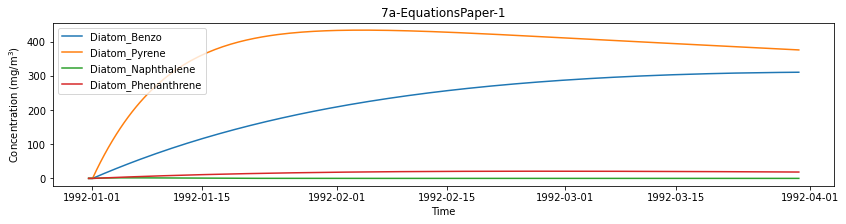

In [13]:
new_group = {}
for pah in groups.pahs:
    new_group['Diatom_'+pah]= 'Diatom_' +pah
group_conc(new_group, scenario_datasets, scenario_paths)

Uptake rates for contaminants in picophytoplankton (PS)
- Picos_Naphthalene_uptake_rate    = 0.00300
- Pico_Phenanthrene_uptake_rate   = 0.00020
- Diatom_Pyrene_uptake_rate         = 0.00014
- Diatom_Benzo_uptake_rate          = 0.00008

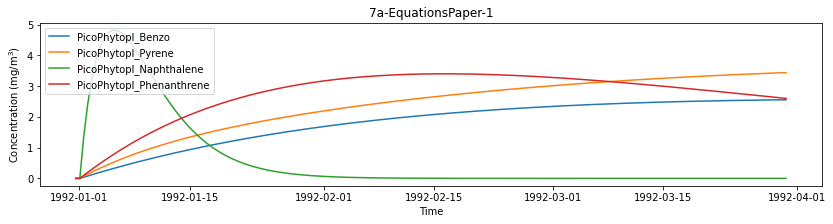

In [14]:
new_group = {}
for pah in groups.pahs:
    new_group['PicoPhytopl_'+pah]= 'PicoPhytopl_' +pah
group_conc(new_group, scenario_datasets, scenario_paths)

## Effects

Using uptake rates from literature values for phytoplankton (low rates)

In [18]:
scenario_root = Path('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/')
scenario_paths = sorted([p for p in scenario_root.glob('7a-EquationsPaper-FHE-effects/outputSalishSea.nc')])
scenario_datasets = [xr.open_dataset(scen,decode_cf=True) for scen in scenario_paths]
scenario_paths

[PosixPath('/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/7a-EquationsPaper-FHE-effects/outputSalishSea.nc')]

### Change in lower trophic levels relative to control

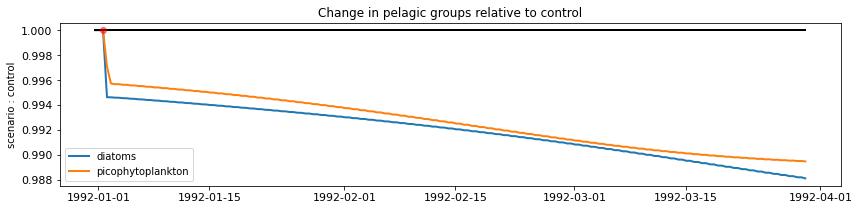

In [22]:
for scenario in scenario_datasets:
    splot.compare_groups_pelagic(groups.phytoplankton, scenario, control, time, start, end, groups.salish_sea, time[2])

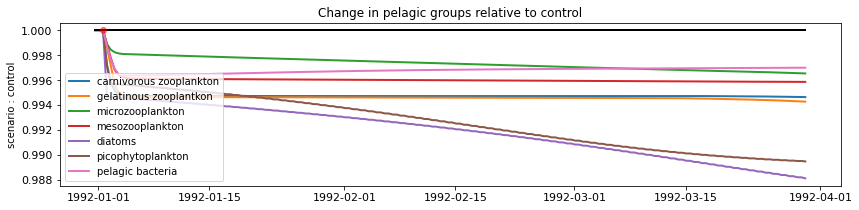

In [23]:
for scenario in scenario_datasets:
    splot.compare_groups_pelagic(groups.plankton, scenario, control, time, start, end, groups.salish_sea, time[2])

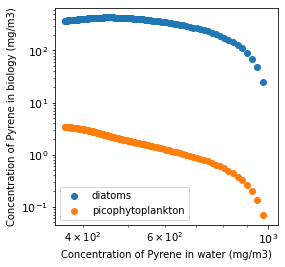

In [32]:
boxes=groups.salish_sea
bio_group = groups.phytoplankton
fig, ax = plt.subplots(figsize = (4,4))
ax.tick_params(labelsize=11)
ax.set_ylabel('Concentration of Pyrene in biology (mg/m3)')
ax.set_xlabel('Concentration of Pyrene in water (mg/m3)')

contam_tbl = np.ma.filled(scenario.variables['Pyrene'][start:end,boxes,0:6], np.nan)
contam_t = contam_tbl.sum(axis=(1,2))
for species in bio_group:
    oiled_tbl = np.ma.filled(scenario.variables[bio_group[species] + '_Pyrene'][start:end,boxes,0:6], np.nan) # tonnes
    oiled_t = oiled_tbl.sum(axis=(1,2))
    ax.scatter(contam_t, oiled_t, label=species)
ax.legend()
ax.set_xscale('log')
ax.set_yscale('log');

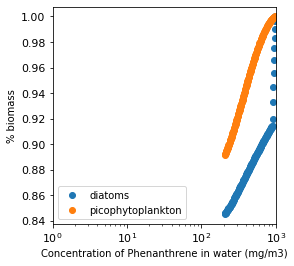

In [44]:
for scenario in scenario_datasets:
    compare_pelagic_versus_pah_chabitat(groups.phytoplankton, 'Phenanthrene',scenario, control, time, start, end, boxes=[1,2,3,4], y_min=None, x_min=1)

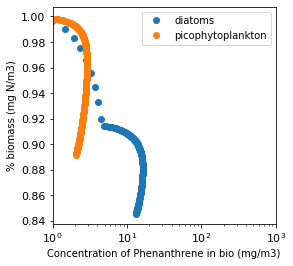

In [45]:
for scenario in scenario_datasets:
    compare_pelagic_versus_pah_cbio(groups.phytoplankton, 'Phenanthrene',scenario, control, time, start, end, boxes=[1,2,3,4], y_min=None, x_min=1)

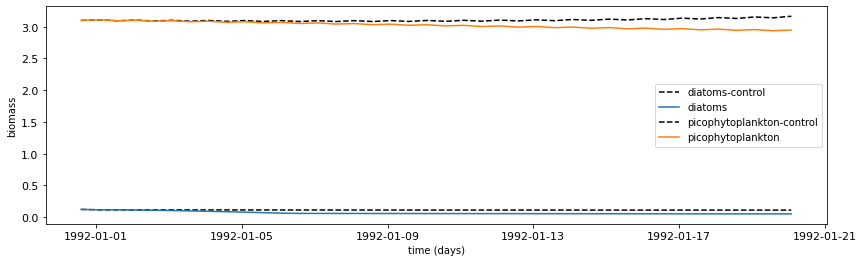

In [65]:
for scenario in scenario_datasets:
    plot_biomass(groups.phytoplankton, scenario, control, time, start, 40, boxes=[1], y_min=None)

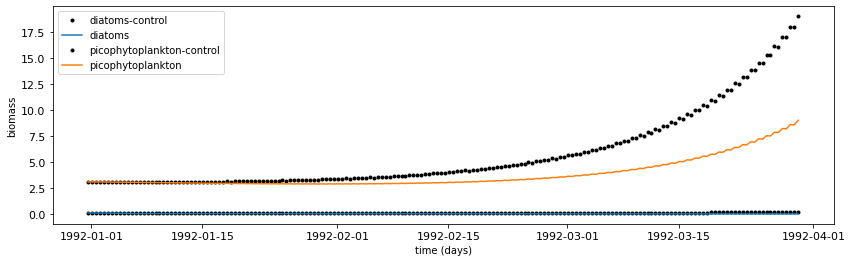

In [59]:
for scenario in scenario_datasets:
    plot_biomass(groups.phytoplankton, scenario, control, time, start, end, boxes=[1], y_min=None)

### Final change at end of simulation

Calculate mean change in biomass for last 5 days of the simulation

In [24]:
boxes = groups.salish_sea
mean_start = end-11
biomass_change = []
bio_group = groups.plankton
for scenario in scenario_datasets:
    for group in bio_group:
        scenario_tbl = np.ma.filled(scenario.variables[bio_group[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
        control_tbl = np.ma.filled(control.variables[bio_group[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
        scenario_tb = scenario_tbl.mean(axis=2)
        control_tb = control_tbl.mean(axis=2)
        scenario_t = scenario_tb.mean(axis=1)
        control_t = control_tb.mean(axis=1)
        biomass_change.append((scenario_t.mean()/control_t.mean()-1)*100)
salish_sea_change = biomass_change
salish_sea_change

[-0.5341066195050592,
 -0.5662199021588155,
 -0.34166257982585213,
 -0.4143193626999442,
 -1.1642187609297472,
 -1.0439289148057918,
 -0.301815438241515]

In [25]:
boxes = groups.juan_de_fuca
mean_start = end-11
biomass_change = []
for scenario in scenario_datasets:
    for group in groups.plankton:
        scenario_tbl = np.ma.filled(scenario.variables[groups.plankton[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
        control_tbl = np.ma.filled(control.variables[groups.plankton[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
        scenario_tb = scenario_tbl.mean(axis=2)
        control_tb = control_tbl.mean(axis=2)
        scenario_t = scenario_tb.mean(axis=1)
        control_t = control_tb.mean(axis=1)
        biomass_change.append((scenario_t.mean()/control_t.mean()-1)*100)
juan_de_fuca_change = biomass_change
juan_de_fuca_change

[-4.794543853911226,
 -5.411932397821328,
 -5.486544485746025,
 -4.657244202440303,
 -5.049341816527764,
 -7.0957512923871535,
 -3.0292049354276873]

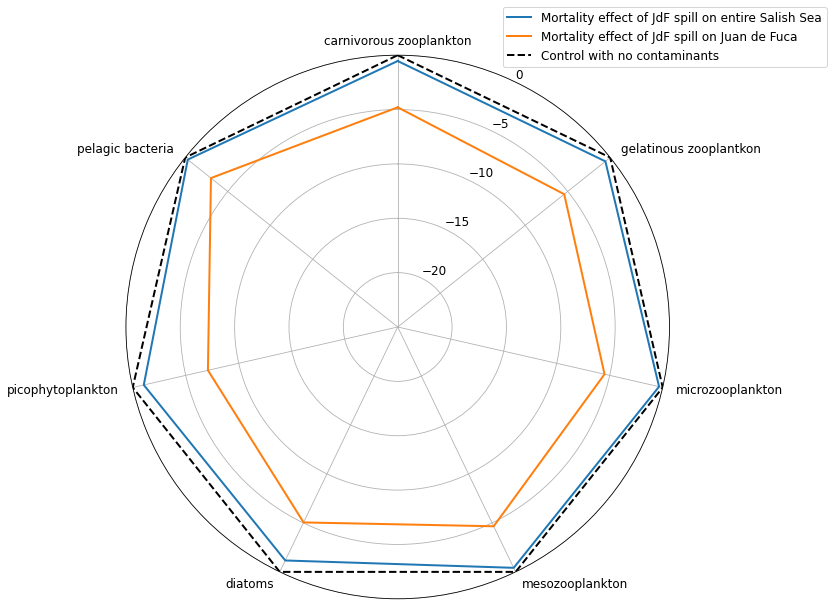

In [26]:
label_size = 11
font_size = 12
line_width = 2
indicators = groups.plankton
num_vars = len(indicators)
angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
angles += angles[:1]
salish_sea_change += salish_sea_change[:1]
juan_de_fuca_change += juan_de_fuca_change[:1]
fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
ax.plot(angles, salish_sea_change, linewidth=line_width, label='Mortality effect of JdF spill on entire Salish Sea')
ax.plot(angles, juan_de_fuca_change, linewidth=line_width, label='Mortality effect of JdF spill on Juan de Fuca')
ax.plot(angles, np.zeros(num_vars+1), 'k--',linewidth=line_width, label='Control with no contaminants')
ax.set_theta_offset(np.pi / 2)
ax.set_theta_direction(-1)
ax.set_rlabel_position(180 / num_vars)
ax.set_ylim(-25, 0)
ax.tick_params(axis='y', labelsize=font_size)
ax.set_xticks(angles[:-1])
ax.set_xticklabels(indicators)
ax.tick_params(axis='x', labelsize=font_size)
for label, angle in zip(ax.get_xticklabels(), angles):
  if angle in (0, np.pi):
    label.set_horizontalalignment('center')
  elif 0 < angle < np.pi:
    label.set_horizontalalignment('left')
  else:
    label.set_horizontalalignment('right')
ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=font_size);

#### Higher trophic levels

In [160]:
def compare_herring_versus_chabitat(pah, cohort, scenario, control, time, start, end, boxes, y_min=None, y_max=None, x_min=0.001, x_max=1000): #bacteria, plankton
    
    fig, ax = plt.subplots(figsize = (4,4))
    ax.tick_params(labelsize=11)
    ax.set_ylabel('% biomass')
    ax.set_xlabel(pah+'_env (mg/m3)')

    c_numbers_tbl = np.ma.filled(control.variables['Pacific_herring'+str(cohort)+'_Nums'][start:end, boxes, 0:6], np.nan)
    c_structuralN_tbl = np.ma.filled(control.variables['Pacific_herring'+str(cohort)+'_StructN'][start:end, boxes, 0:6], np.nan)
    c_reservedN_tbl = np.ma.filled(control.variables['Pacific_herring'+str(cohort)+'_ResN'][start:end, boxes, 0:6], np.nan)

    c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl) * c_numbers_tbl 
    c_weightatage_t = c_weightatage_tbl.sum(axis=(1,2))

    o_numbers_tbl = np.ma.filled(scenario.variables['Pacific_herring'+str(cohort)+'_Nums'][start:end, boxes, 0:6], np.nan)
    o_structuralN_tbl = np.ma.filled(scenario.variables['Pacific_herring'+str(cohort)+'_StructN'][start:end, boxes, 0:6], np.nan)
    o_reservedN_tbl = np.ma.filled(scenario.variables['Pacific_herring'+str(cohort)+'_ResN'][start:end, boxes, 0:6], np.nan)

    o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl 
    o_weightatage_t = o_weightatage_tbl.sum(axis=(1,2))

    ratio = o_weightatage_t / c_weightatage_t         
    np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/"+scen_name+"/Pacific-Herring"+str(cohort)+"-ratio.csv", ratio, delimiter = ",")

    contam_tbl = np.ma.filled(scenario.variables[pah][start:end,boxes,0:6], np.nan)
    contam_t = contam_tbl.sum(axis=(1,2))
    #np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/"+scen_name+"/"+str(pah)+"-in-juan-de-fuca.csv", contam_t, delimiter = ",")
    ax.semilogx(contam_t, ratio, )
    #ax.legend()
    #ax.set_xscale('log')
    #ax.set_ylim([y_min, y_max])
    #ax.set_xlim([x_min, x_max])
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)

In [116]:
def compare_herring_versus_cbio(pah, cohort, scenario, control, time, start, end, boxes, y_min=None, y_max=None, x_min=0.001, x_max=1000): #bacteria, plankton
    
    fig, ax = plt.subplots(figsize = (4,4))
    ax.tick_params(labelsize=11)
    ax.set_ylabel('% biomass')
    ax.set_xlabel(pah+'_bio (mg/m3)')

    c_numbers_tbl = np.ma.filled(control.variables['Pacific_herring'+str(cohort)+'_Nums'][start:end, boxes, 0:6], np.nan)
    c_structuralN_tbl = np.ma.filled(control.variables['Pacific_herring'+str(cohort)+'_StructN'][start:end, boxes, 0:6], np.nan)
    c_reservedN_tbl = np.ma.filled(control.variables['Pacific_herring'+str(cohort)+'_ResN'][start:end, boxes, 0:6], np.nan)

    c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl) * c_numbers_tbl 
    c_weightatage_t = c_weightatage_tbl.sum(axis=(1,2))

    o_numbers_tbl = np.ma.filled(scenario.variables['Pacific_herring'+str(cohort)+'_Nums'][start:end, boxes, 0:6], np.nan)
    o_structuralN_tbl = np.ma.filled(scenario.variables['Pacific_herring'+str(cohort)+'_StructN'][start:end, boxes, 0:6], np.nan)
    o_reservedN_tbl = np.ma.filled(scenario.variables['Pacific_herring'+str(cohort)+'_ResN'][start:end, boxes, 0:6], np.nan)

    o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl 
    o_weightatage_t = o_weightatage_tbl.sum(axis=(1,2))

    ratio = o_weightatage_t / c_weightatage_t         
    #np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/"+scen_name+"/Pacific-Herring1-ratio"+str(pah)+".csv", ratio, delimiter = ",")

    contam_tbl = np.ma.filled(scenario.variables['Pacific_herring1_'+pah][start:end,boxes,0:6], np.nan)
    contam_t = contam_tbl.sum(axis=(1,2))
    np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Spills/"+scen_name+"/FHE1_"+str(pah)+".csv", contam_t, delimiter = ",")
    ax.semilogx(contam_t, ratio, 'o')
    #ax.legend()
    #ax.set_xscale('log')
    #ax.set_ylim([y_min, y_max])
    #ax.set_xlim([x_min, x_max])
    #ax.plot([spill_end, spill_end], [y_min, y_max], 'r',alpha=0.1)

In [ ]:
for scenario in scenario_datasets:
    for cohort in range (1, groups.cohorts['Pacific_herring']+1):
        compare_herring_versus_chabitat('Pyrene',cohort, scenario, control, time, start, end, boxes=[1], y_min=None, x_min=1)

In [ ]:
for scenario in scenario_datasets:
    for pah in groups.pahs:
        compare_herring_versus_cbio(pah,scenario, control, time, start, end, boxes=[1,2,3,4], y_min=None, x_min=1)

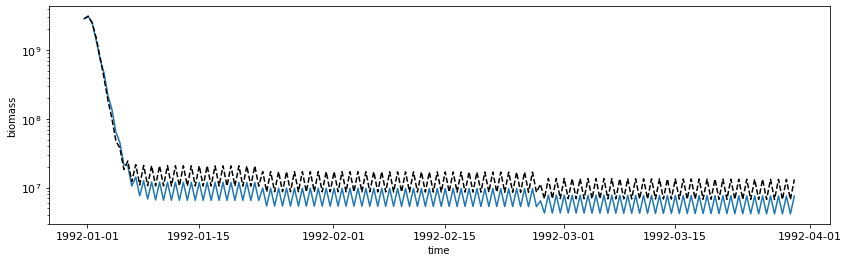

In [165]:
boxes = [1]
cohort=3
fig, ax = plt.subplots(figsize = (14,4))
ax.tick_params(labelsize=11)
ax.set_ylabel('biomass')
ax.set_xlabel('time')

c_numbers_tbl = np.ma.filled(control.variables['Pacific_herring'+str(cohort)+'_Nums'][start:end, boxes, 0:6], np.nan)
c_structuralN_tbl = np.ma.filled(control.variables['Pacific_herring'+str(cohort)+'_StructN'][start:end, boxes, 0:6], np.nan)
c_reservedN_tbl = np.ma.filled(control.variables['Pacific_herring'+str(cohort)+'_ResN'][start:end, boxes, 0:6], np.nan)

c_weightatage_tbl = (c_structuralN_tbl + c_reservedN_tbl) * c_numbers_tbl 
c_weightatage_t = c_weightatage_tbl.sum(axis=(1,2))

o_numbers_tbl = np.ma.filled(scenario.variables['Pacific_herring'+str(cohort)+'_Nums'][start:end, boxes, 0:6], np.nan)
o_structuralN_tbl = np.ma.filled(scenario.variables['Pacific_herring'+str(cohort)+'_StructN'][start:end, boxes, 0:6], np.nan)
o_reservedN_tbl = np.ma.filled(scenario.variables['Pacific_herring'+str(cohort)+'_ResN'][start:end, boxes, 0:6], np.nan)

o_weightatage_tbl = (o_structuralN_tbl + o_reservedN_tbl) * o_numbers_tbl 
o_weightatage_t = o_weightatage_tbl.sum(axis=(1,2))
ax.semilogy(time[start:end], o_weightatage_t, )
ax.semilogy(time[start:end], c_weightatage_t, 'k--')

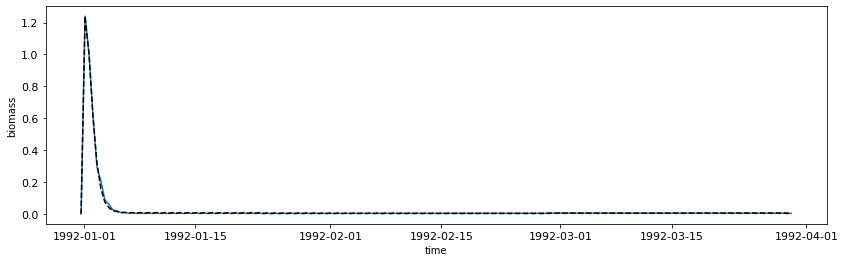

In [166]:
fig, ax = plt.subplots(figsize = (14,4))
ax.tick_params(labelsize=11)
ax.set_ylabel('biomass')
ax.set_xlabel('time')

c_tbl = np.ma.filled(control.variables['Pacific_herring_N'][start:end, boxes, 0:6], np.nan)
c_t = c_tbl.sum(axis=(1,2))

o_tbl = np.ma.filled(scenario.variables['Pacific_herring_N'][start:end, boxes, 0:6], np.nan)
o_t = o_tbl.sum(axis=(1,2))
ax.plot(time[start:end], o_t, )
ax.plot(time[start:end], c_t, 'k--')

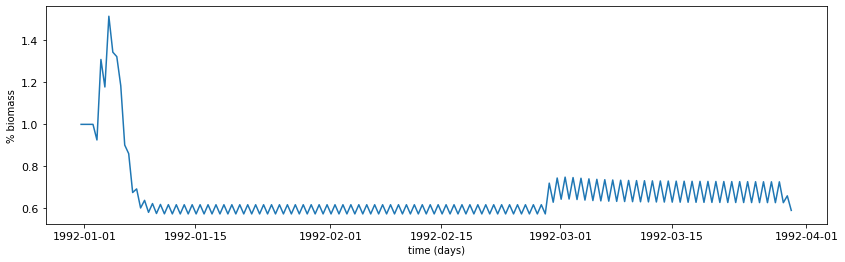

In [167]:
fig, ax = plt.subplots(figsize = (14,4))
ax.tick_params(labelsize=11)
ax.set_ylabel('% biomass')
ax.set_xlabel('time (days)')

ax.plot(time[start:end], o_t/c_t)
#ax.plot(contam_t, c_t, 'k--')

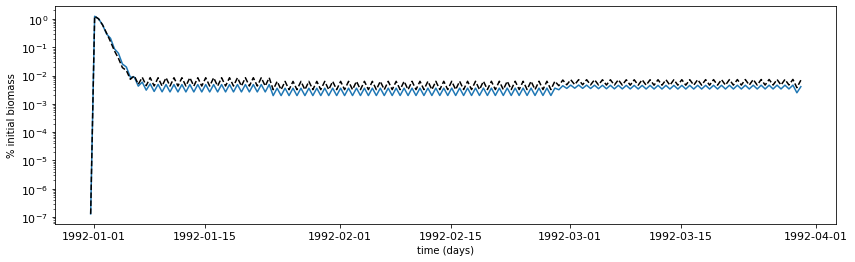

In [168]:
fig, ax = plt.subplots(figsize = (14,4))
ax.tick_params(labelsize=11)
ax.set_ylabel('% initial biomass')
ax.set_xlabel('time (days)')

ax.semilogy(time[start:end], o_t,)
ax.semilogy(time[start:end], c_t, 'k--')

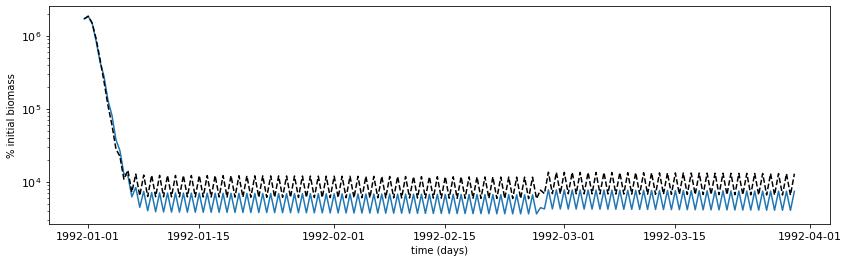

In [169]:
fig, ax = plt.subplots(figsize = (14,4))
ax.tick_params(labelsize=11)
ax.set_ylabel('% initial biomass')
ax.set_xlabel('time (days)')

ax.semilogy(time[start:end], o_numbers_tbl.sum(axis=(1,2)),)
ax.semilogy(time[start:end], c_numbers_tbl.sum(axis=(1,2)), 'k--')

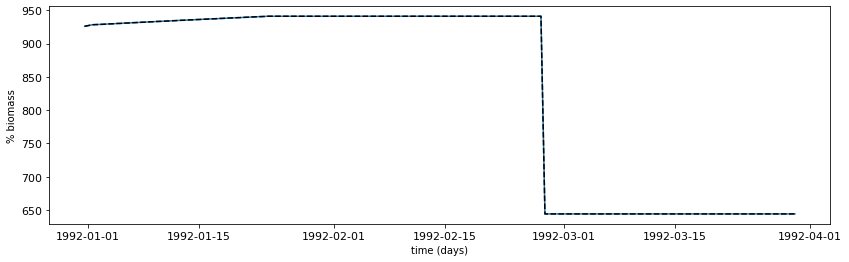

In [170]:
fig, ax = plt.subplots(figsize = (14,4))
ax.tick_params(labelsize=11)
ax.set_ylabel('% biomass')
ax.set_xlabel('time (days)')

ax.plot(time[start:end], o_structuralN_tbl.sum(axis=(1,2)), )
ax.plot(time[start:end], c_structuralN_tbl.sum(axis=(1,2)), 'k--')

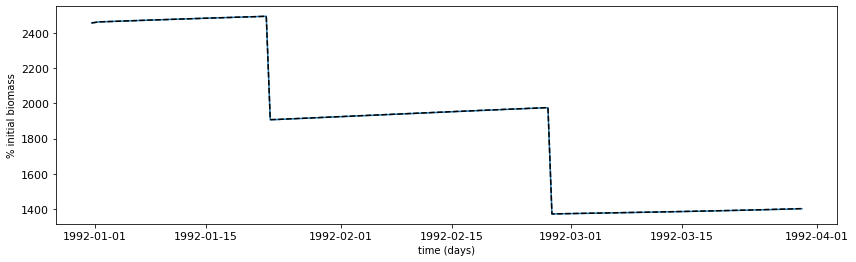

In [171]:
fig, ax = plt.subplots(figsize = (14,4))
ax.tick_params(labelsize=11)
ax.set_ylabel('% initial biomass')
ax.set_xlabel('time (days)')

ax.plot(time[start:end], o_reservedN_tbl.sum(axis=(1,2)),)
ax.plot(time[start:end], c_reservedN_tbl.sum(axis=(1,2)), 'k--')

In [91]:
Pacific_herring_ratio = o_weightatage_t/c_weightatage_t

In [92]:
np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Pacific-Herring1-ratio-ALC.csv", Pacific_herring_ratio, delimiter = ",")

In [93]:
Pacific_herring_mortality = (c_weightatage_t - o_weightatage_t)/c_weightatage_t
np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Pacific-Herring1-mortality-ALC.csv", Pacific_herring_mortality, delimiter = ",")

In [100]:
Pacific_herring_Naph_tbl = np.ma.filled(scenario.variables['Pacific_herring1_Naphthalene'][start:end, boxes, 0:6], np.nan)
Pacific_herring_Naph_t = Pacific_herring_Naph_tbl.sum(axis=(1,2))
np.savetxt("/ocean/rlovindeer/MOAD/analysis-raisha/SSmodel_outputs/Pacific-Herring1-Naph-ANSC.csv", Pacific_herring_Naph_t, delimiter = ",")

- Biomass = mgN/m3 (XXX_N)
- Growth = structural N / individual of a oldest cohort (XXX_StructN/XXX_Nums)
- Reproduction = numbers of cohort 1 (XX1_Nums)

In [28]:

def plot_radar_biomass_growth_reprod(bio_group, boxes, mean_start, end):
    for scenario in scenario_datasets:
        biomass_change = []
        for group in bio_group:
            scenario_tbl = np.ma.filled(scenario.variables[bio_group[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
            control_tbl = np.ma.filled(control.variables[bio_group[group]+'_N'][mean_start:end,boxes,0:6], np.nan)
            scenario_tb = scenario_tbl.mean(axis=2)
            control_tb = control_tbl.mean(axis=2)
            scenario_t = scenario_tb.mean(axis=1)
            control_t = control_tb.mean(axis=1)
            biomass_change.append((scenario_t.mean()/control_t.mean()-1)*100)
        biomass_change += biomass_change[:1]

        growth_change = []
        for group in bio_group:
            scenario_tbl = np.ma.filled(scenario.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_StructN'][mean_start:end,boxes,0:6], np.nan)
            scenario_nums_tbl = np.ma.filled(scenario.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_Nums'][mean_start:end,boxes,0:6], np.nan)
            control_tbl = np.ma.filled(control.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_StructN'][mean_start:end,boxes,0:6], np.nan)
            control_nums_tbl = np.ma.filled(scenario.variables[bio_group[group]+str(groups.cohorts[bio_group[group]])+'_Nums'][mean_start:end,boxes,0:6], np.nan)
            scenario_growth_tbl = scenario_tbl * (1/(scenario_nums_tbl+(scenario_nums_tbl==0)))
            control_growth_tbl = control_tbl * (1/(control_nums_tbl+(control_nums_tbl==0)))
            scenario_growth_tb = scenario_growth_tbl.mean(axis=2)
            control_growth_tb = control_growth_tbl.mean(axis=2)
            scenario_growth_t = scenario_growth_tb.mean(axis=1)
            control_growth_t = control_growth_tb.mean(axis=1)
            growth_change.append((scenario_growth_t.mean()/control_growth_t.mean()-1)*100)
        growth_change += growth_change[:1]

        reprod_change = []
        for group in bio_group:
            scenario_tbl = np.ma.filled(scenario.variables[bio_group[group]+'1_Nums'][mean_start:end,boxes,0:6], np.nan)
            control_tbl = np.ma.filled(control.variables[bio_group[group]+'1_Nums'][mean_start:end,boxes,0:6], np.nan)
            scenario_tb = scenario_tbl.mean(axis=2)
            control_tb = control_tbl.mean(axis=2)
            scenario_t = scenario_tb.mean(axis=1)
            control_t = control_tb.mean(axis=1)
            reprod_change.append((scenario_t.mean()/control_t.mean()-1)*100)
        reprod_change += reprod_change[:1]

        data_values = {'Contaminant effect on biomass':biomass_change,'Contaminant effect on growth':growth_change,'Contaminant effect on reproduction':reprod_change}
        num_vars = len(bio_group)
        angles = np.linspace(0, 2 * np.pi, num_vars, endpoint=False).tolist()
        angles += angles[:1]
        fig, ax = plt.subplots(figsize=(10, 10), subplot_kw=dict(polar=True))
        for item in data_values:
            ax.plot(angles, data_values[item], linewidth=line_width, label=item)
        ax.plot(angles, np.zeros(num_vars+1), 'k--',linewidth=line_width, label='Control, no contaminants')
        ax.set_theta_offset(np.pi / 2)
        ax.set_theta_direction(-1)
        ax.set_rlabel_position(180 / num_vars)
        ax.set_ylim(-5, 0)
        ax.tick_params(axis='y', labelsize=font_size)
        ax.set_xticks(angles[:-1])
        ax.set_xticklabels(bio_group)
        ax.tick_params(axis='x', labelsize=font_size)
        for label, angle in zip(ax.get_xticklabels(), angles):
            if angle in (0, np.pi):
                label.set_horizontalalignment('center')
            elif 0 < angle < np.pi:
                label.set_horizontalalignment('left')
            else:
                label.set_horizontalalignment('right')
        ax.legend(loc='upper right', bbox_to_anchor=(1.3, 1.1), fontsize=font_size);

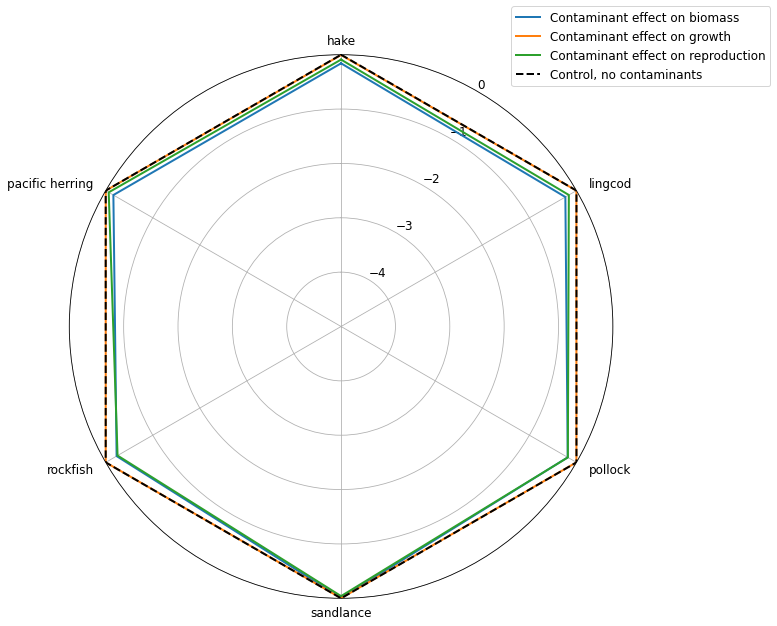

In [31]:
boxes = groups.salish_sea
mean_start = end-11
bio_group = groups.named_fish
plot_radar_biomass_growth_reprod(bio_group, boxes, mean_start, end)

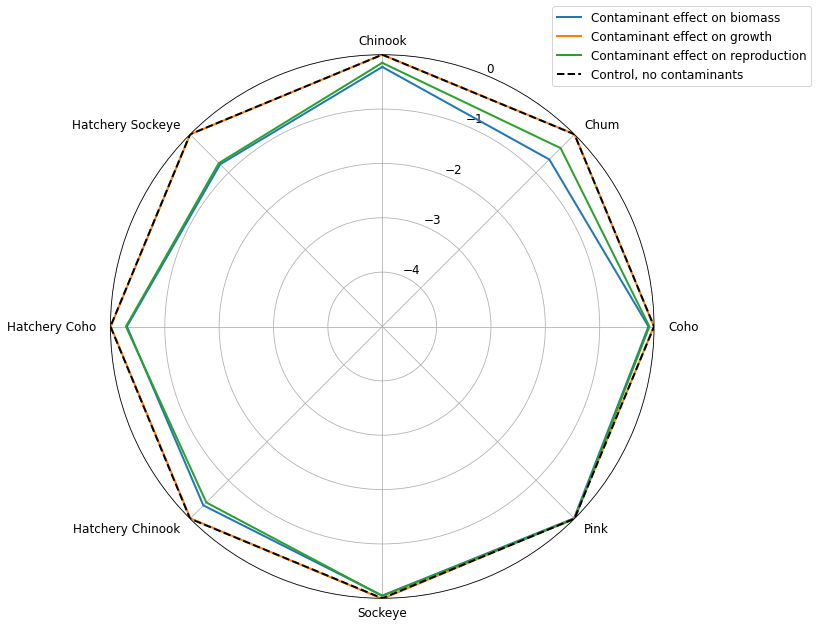

In [32]:
plot_radar_biomass_growth_reprod(groups.salmon, boxes, mean_start, end)

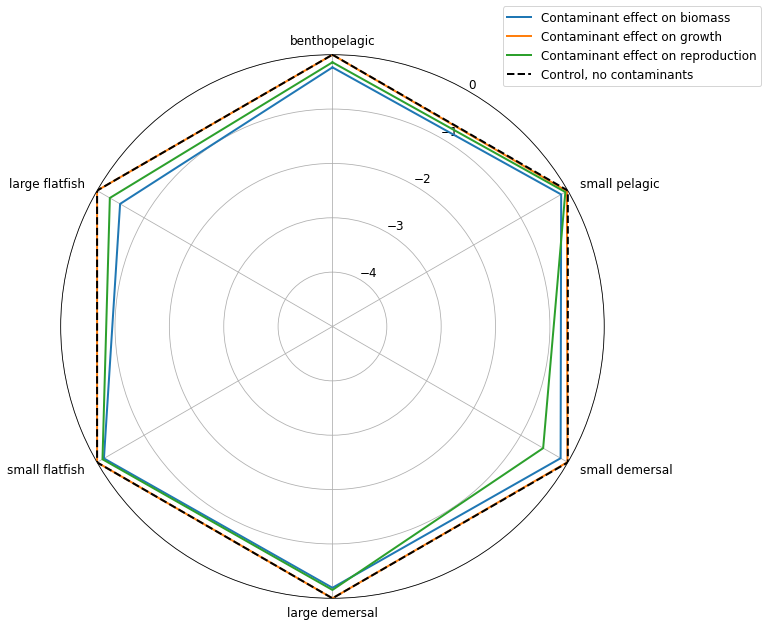

In [33]:
plot_radar_biomass_growth_reprod(groups.other_fish, boxes, mean_start, end)

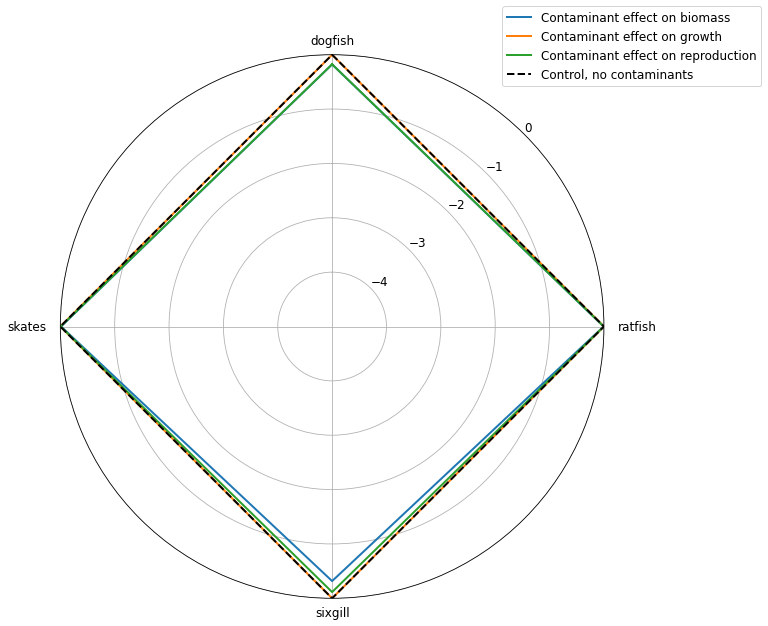

In [34]:
plot_radar_biomass_growth_reprod(groups.sharks, boxes, mean_start, end)

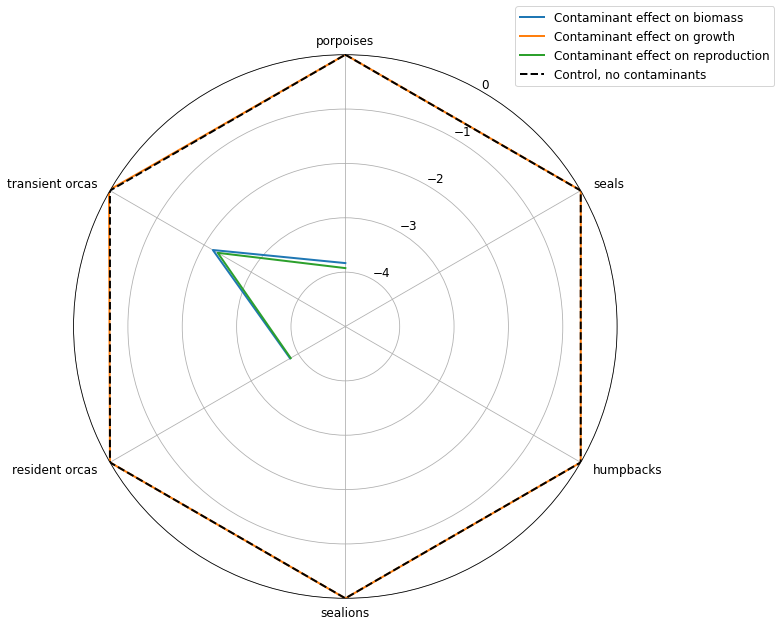

In [35]:
plot_radar_biomass_growth_reprod(groups.mammals, boxes, mean_start, end)